In [9]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from functions import *
from functions import plotting

(2115, 22, 1000)
(2115,)
(443, 22, 1000)
(443,)


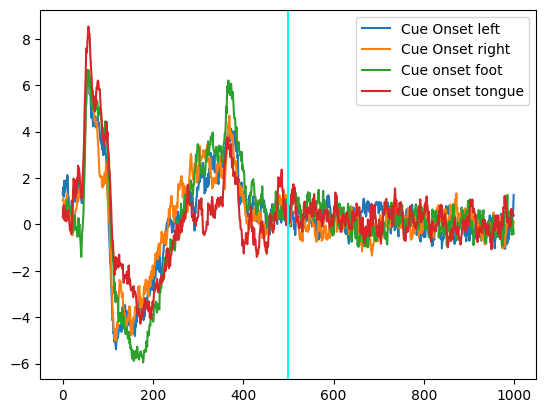

In [10]:
## Loading and visualizing the data

## Loading the dataset
X_test = np.load("../ECEC147project-data/X_test.npy")
y_test = np.load("../ECEC147project-data//y_test.npy")
person_train_valid = np.load("../ECEC147project-data//person_train_valid.npy")
X_train_valid = np.load("../ECEC147project-data/X_train_valid.npy")
y_train_valid = np.load("../ECEC147project-data/y_train_valid.npy")
person_test = np.load("../ECEC147project-data/person_test.npy")

print(np.shape(X_train_valid))
print(np.shape(y_train_valid))
print(np.shape(X_test))
print(np.shape(y_test))

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data
ch_data = X_train_valid[:,8,:]
class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)

plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [11]:
def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):
    
    total_X = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X




In [12]:
print(np.shape(X_train_valid))
print(np.shape(y_train_valid))
print(np.shape(X_test))
print(np.shape(y_test))
# Preprocessing test dataset
X_test_prep = test_data_prep(X_test) 

## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 250, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# First split then do preprocessing separately
# Creating the training and validation sets using the generated indices
(x_train_split, x_valid_split) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train_split, y_valid_split) = y_train_valid[ind_train], y_train_valid[ind_valid]

# Preprocessing the dataset after split to prevent leakage (augmentation and smoothing)
x_train,y_train = train_data_prep(x_train_split,y_train_split,2,2,True)
x_valid,y_valid = train_data_prep(x_valid_split,y_valid_split,2,2,True)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)
print(np.shape(x_test))
print(np.shape(y_test))


(2115, 22, 1000)
(2115,)
(443, 22, 1000)
(443,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (1865, 22, 800)
Shape of X after maxpooling: (1865, 22, 400)
Shape of X after averaging+noise and concatenating: (3730, 22, 400)
Shape of X after subsampling and concatenating: (7460, 22, 400)
Shape of Y: (7460,)
Shape of X after trimming: (250, 22, 800)
Shape of X after maxpooling: (250, 22, 400)
Shape of X after averaging+noise and concatenating: (500, 22, 400)
Shape of X after subsampling and concatenating: (1000, 22, 400)
Shape of Y: (1000,)
Shape of training set: (7460, 22, 400)
Shape of validation set: (1000, 22, 400)
Shape of training labels: (7460,)
Shape of validation labels: (1000,)
Shape of training labels after categorical conversion: (7460, 4)
Shape of validation labels after categorical conversion: (1000, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: 

(1000, 400, 1, 22)
(1000, 400, 22)
(1000, 400)


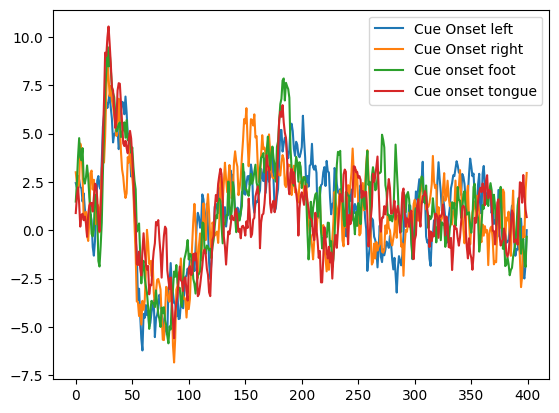

In [13]:
print(x_valid.shape)

ch_data1 = x_valid[:,:,0]
print(ch_data1.shape)
ch_data1 = ch_data1[:, :, 8]
print(ch_data1.shape)
class_0_ind = np.where(y_valid[:, 0] == 1)
ch_data_class_0 = ch_data1[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)

class_1_ind = np.where(y_valid[:, 1] == 1)
ch_data_class_1 = ch_data1[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_valid[:, 2] == 1)
ch_data_class_2 = ch_data1[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_valid[:, 3] == 1)
ch_data_class_3 = ch_data1[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)

plt.plot(np.arange(400),avg_ch_data_class_0)
plt.plot(np.arange(400),avg_ch_data_class_1)
plt.plot(np.arange(400),avg_ch_data_class_2)
plt.plot(np.arange(400),avg_ch_data_class_3)

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [14]:
# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(5,5), padding='same', activation='elu', input_shape=(400,1,22)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 4
hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((40))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model.add(LSTM(10, dropout=0.4, recurrent_dropout=0.1, input_shape=(40,1), return_sequences=False))


# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 400, 1, 25)        13775     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 134, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_8 (Bat  (None, 134, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 134, 1, 25)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 134, 1, 50)        31300     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 45, 1, 50)        

In [15]:
# Model parameters
learning_rate = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
epochs = [100, 125, 150, 175, 200]
# epochs = 150
# learning_rate = 1e-2
hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(lr=learning_rate)

In [16]:
learning_rate_accuracy = []
epochs_accuracy = []

for i in range (len(learning_rate)):
    hybrid_cnn_lstm_model = hybrid()
    hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(learning_rate=learning_rate[i])
    # Compiling the model
    hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                    optimizer=hybrid_cnn_lstm_optimizer,
                    metrics=['accuracy'])

    # Training and validating the model
    hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
                y_train,
                batch_size=64,
                epochs=100,
                validation_data=(x_valid, y_valid), verbose=True)
    # Testing accuracy 
    hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
    learning_rate_accuracy.append(hybrid_cnn_lstm_score[1])

for i in range (len(epochs)):
    hybrid_cnn_lstm_model = hybrid()
    hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(1e-3)
    # Compiling the model
    hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                    optimizer=hybrid_cnn_lstm_optimizer,
                    metrics=['accuracy'])

    # Training and validating the model
    hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
                y_train,
                batch_size=64,
                epochs=epochs[i],
                validation_data=(x_valid, y_valid), verbose=True)
    # Testing accuracy 
    hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
    epochs_accuracy.append(hybrid_cnn_lstm_score[1])

Epoch 1/100
117/117 [==============================] - 19s 142ms/step - loss: 1.3962 - accuracy: 0.2449 - val_loss: 1.3860 - val_accuracy: 0.2560
Epoch 2/100
117/117 [==============================] - 16s 137ms/step - loss: 1.3965 - accuracy: 0.2495 - val_loss: 1.3855 - val_accuracy: 0.2410
Epoch 3/100
117/117 [==============================] - 16s 137ms/step - loss: 1.3918 - accuracy: 0.2584 - val_loss: 1.3856 - val_accuracy: 0.2650
Epoch 4/100
117/117 [==============================] - 16s 138ms/step - loss: 1.3921 - accuracy: 0.2599 - val_loss: 1.3865 - val_accuracy: 0.2500
Epoch 5/100
117/117 [==============================] - 16s 140ms/step - loss: 1.3924 - accuracy: 0.2563 - val_loss: 1.3879 - val_accuracy: 0.2550
Epoch 6/100
117/117 [==============================] - 17s 141ms/step - loss: 1.3924 - accuracy: 0.2559 - val_loss: 1.3888 - val_accuracy: 0.2550
Epoch 7/100
117/117 [==============================] - 16s 138ms/step - loss: 1.3891 - accuracy: 0.2574 - val_loss: 1.3887 -

Epoch 1/100
117/117 [==============================] - 11s 80ms/step - loss: 1.3972 - accuracy: 0.2441 - val_loss: 1.3905 - val_accuracy: 0.2180
Epoch 2/100
117/117 [==============================] - 9s 79ms/step - loss: 1.3880 - accuracy: 0.2576 - val_loss: 1.3949 - val_accuracy: 0.2160
Epoch 3/100
117/117 [==============================] - 9s 79ms/step - loss: 1.3894 - accuracy: 0.2512 - val_loss: 1.4002 - val_accuracy: 0.2160
Epoch 4/100
117/117 [==============================] - 9s 79ms/step - loss: 1.3832 - accuracy: 0.2753 - val_loss: 1.4003 - val_accuracy: 0.2150
Epoch 5/100
117/117 [==============================] - 9s 80ms/step - loss: 1.3832 - accuracy: 0.2713 - val_loss: 1.3937 - val_accuracy: 0.2320
Epoch 6/100
117/117 [==============================] - 9s 79ms/step - loss: 1.3817 - accuracy: 0.2763 - val_loss: 1.3935 - val_accuracy: 0.2370
Epoch 7/100
117/117 [==============================] - 9s 79ms/step - loss: 1.3761 - accuracy: 0.2851 - val_loss: 1.3968 - val_accuracy

Epoch 1/100
117/117 [==============================] - 12s 82ms/step - loss: 1.3730 - accuracy: 0.2861 - val_loss: 1.3489 - val_accuracy: 0.3440
Epoch 2/100
117/117 [==============================] - 9s 77ms/step - loss: 1.3277 - accuracy: 0.3480 - val_loss: 1.2937 - val_accuracy: 0.4040
Epoch 3/100
117/117 [==============================] - 9s 76ms/step - loss: 1.2783 - accuracy: 0.4008 - val_loss: 1.2294 - val_accuracy: 0.4620
Epoch 4/100
117/117 [==============================] - 9s 77ms/step - loss: 1.2314 - accuracy: 0.4355 - val_loss: 1.2597 - val_accuracy: 0.4210
Epoch 5/100
117/117 [==============================] - 9s 77ms/step - loss: 1.2030 - accuracy: 0.4594 - val_loss: 1.2256 - val_accuracy: 0.4550
Epoch 6/100
117/117 [==============================] - 9s 77ms/step - loss: 1.1845 - accuracy: 0.4662 - val_loss: 1.2286 - val_accuracy: 0.4430
Epoch 7/100
117/117 [==============================] - 9s 78ms/step - loss: 1.1757 - accuracy: 0.4731 - val_loss: 1.2664 - val_accuracy

Epoch 1/100
117/117 [==============================] - 11s 80ms/step - loss: 1.3517 - accuracy: 0.3214 - val_loss: 1.3083 - val_accuracy: 0.3680
Epoch 2/100
117/117 [==============================] - 9s 78ms/step - loss: 1.2720 - accuracy: 0.4056 - val_loss: 1.3049 - val_accuracy: 0.3560
Epoch 3/100
117/117 [==============================] - 9s 79ms/step - loss: 1.2386 - accuracy: 0.4288 - val_loss: 1.2383 - val_accuracy: 0.3930
Epoch 4/100
117/117 [==============================] - 9s 79ms/step - loss: 1.2234 - accuracy: 0.4322 - val_loss: 1.2330 - val_accuracy: 0.4480
Epoch 5/100
117/117 [==============================] - 9s 79ms/step - loss: 1.1972 - accuracy: 0.4531 - val_loss: 1.2195 - val_accuracy: 0.4400
Epoch 6/100
117/117 [==============================] - 9s 80ms/step - loss: 1.1775 - accuracy: 0.4634 - val_loss: 1.2885 - val_accuracy: 0.4170
Epoch 7/100
117/117 [==============================] - 9s 79ms/step - loss: 1.1771 - accuracy: 0.4619 - val_loss: 1.2783 - val_accuracy

Epoch 1/100
117/117 [==============================] - 11s 80ms/step - loss: 1.4033 - accuracy: 0.2484 - val_loss: 1.3915 - val_accuracy: 0.2560
Epoch 2/100
117/117 [==============================] - 9s 78ms/step - loss: 1.3964 - accuracy: 0.2408 - val_loss: 1.4517 - val_accuracy: 0.2440
Epoch 3/100
117/117 [==============================] - 9s 78ms/step - loss: 1.3974 - accuracy: 0.2416 - val_loss: 1.3968 - val_accuracy: 0.2160
Epoch 4/100
117/117 [==============================] - 9s 79ms/step - loss: 1.3953 - accuracy: 0.2418 - val_loss: 1.3929 - val_accuracy: 0.2560
Epoch 5/100
117/117 [==============================] - 9s 79ms/step - loss: 1.3966 - accuracy: 0.2520 - val_loss: 1.4179 - val_accuracy: 0.2160
Epoch 6/100
117/117 [==============================] - 9s 79ms/step - loss: 1.3964 - accuracy: 0.2540 - val_loss: 1.4013 - val_accuracy: 0.2560
Epoch 7/100
117/117 [==============================] - 9s 78ms/step - loss: 1.3991 - accuracy: 0.2434 - val_loss: 1.4024 - val_accuracy

Epoch 1/100
117/117 [==============================] - 11s 78ms/step - loss: 1.3691 - accuracy: 0.2890 - val_loss: 1.3412 - val_accuracy: 0.3480
Epoch 2/100
117/117 [==============================] - 9s 76ms/step - loss: 1.2992 - accuracy: 0.3945 - val_loss: 1.2219 - val_accuracy: 0.4710
Epoch 3/100
117/117 [==============================] - 9s 76ms/step - loss: 1.2495 - accuracy: 0.4239 - val_loss: 1.1967 - val_accuracy: 0.4630
Epoch 4/100
117/117 [==============================] - 9s 75ms/step - loss: 1.2038 - accuracy: 0.4538 - val_loss: 1.1784 - val_accuracy: 0.4980
Epoch 5/100
117/117 [==============================] - 9s 76ms/step - loss: 1.1874 - accuracy: 0.4654 - val_loss: 1.1785 - val_accuracy: 0.4580
Epoch 6/100
117/117 [==============================] - 9s 76ms/step - loss: 1.1639 - accuracy: 0.4728 - val_loss: 1.1937 - val_accuracy: 0.4700
Epoch 7/100
117/117 [==============================] - 9s 76ms/step - loss: 1.1319 - accuracy: 0.4954 - val_loss: 1.1624 - val_accuracy

Epoch 1/125
117/117 [==============================] - 11s 80ms/step - loss: 1.3734 - accuracy: 0.2865 - val_loss: 1.3420 - val_accuracy: 0.3350
Epoch 2/125
117/117 [==============================] - 9s 77ms/step - loss: 1.3235 - accuracy: 0.3513 - val_loss: 1.2874 - val_accuracy: 0.3680
Epoch 3/125
117/117 [==============================] - 9s 76ms/step - loss: 1.2704 - accuracy: 0.4064 - val_loss: 1.2390 - val_accuracy: 0.4290
Epoch 4/125
117/117 [==============================] - 9s 77ms/step - loss: 1.2227 - accuracy: 0.4433 - val_loss: 1.2243 - val_accuracy: 0.4240
Epoch 5/125
117/117 [==============================] - 9s 76ms/step - loss: 1.1972 - accuracy: 0.4599 - val_loss: 1.2097 - val_accuracy: 0.4400
Epoch 6/125
117/117 [==============================] - 9s 77ms/step - loss: 1.1769 - accuracy: 0.4689 - val_loss: 1.2400 - val_accuracy: 0.4230
Epoch 7/125
117/117 [==============================] - 9s 77ms/step - loss: 1.1519 - accuracy: 0.4838 - val_loss: 1.2037 - val_accuracy

Epoch 1/150
117/117 [==============================] - 11s 78ms/step - loss: 1.3801 - accuracy: 0.2878 - val_loss: 1.3655 - val_accuracy: 0.3320
Epoch 2/150
117/117 [==============================] - 9s 78ms/step - loss: 1.3485 - accuracy: 0.3302 - val_loss: 1.3292 - val_accuracy: 0.3390
Epoch 3/150
117/117 [==============================] - 9s 78ms/step - loss: 1.3047 - accuracy: 0.3799 - val_loss: 1.2710 - val_accuracy: 0.3680
Epoch 4/150
117/117 [==============================] - 9s 78ms/step - loss: 1.2623 - accuracy: 0.4190 - val_loss: 1.2359 - val_accuracy: 0.4210
Epoch 5/150
117/117 [==============================] - 9s 79ms/step - loss: 1.2180 - accuracy: 0.4483 - val_loss: 1.2723 - val_accuracy: 0.3840
Epoch 6/150
117/117 [==============================] - 9s 79ms/step - loss: 1.1774 - accuracy: 0.4775 - val_loss: 1.1596 - val_accuracy: 0.4860
Epoch 7/150
117/117 [==============================] - 9s 79ms/step - loss: 1.1559 - accuracy: 0.4826 - val_loss: 1.2373 - val_accuracy

Epoch 1/175
117/117 [==============================] - 12s 78ms/step - loss: 1.3824 - accuracy: 0.2772 - val_loss: 1.3730 - val_accuracy: 0.3250
Epoch 2/175
117/117 [==============================] - 9s 75ms/step - loss: 1.3551 - accuracy: 0.3202 - val_loss: 1.3352 - val_accuracy: 0.3550
Epoch 3/175
117/117 [==============================] - 9s 75ms/step - loss: 1.3060 - accuracy: 0.3717 - val_loss: 1.2561 - val_accuracy: 0.4270
Epoch 4/175
117/117 [==============================] - 9s 75ms/step - loss: 1.2621 - accuracy: 0.4145 - val_loss: 1.2396 - val_accuracy: 0.4400
Epoch 5/175
117/117 [==============================] - 9s 76ms/step - loss: 1.2400 - accuracy: 0.4350 - val_loss: 1.2389 - val_accuracy: 0.4440
Epoch 6/175
117/117 [==============================] - 9s 75ms/step - loss: 1.2188 - accuracy: 0.4371 - val_loss: 1.2215 - val_accuracy: 0.4490
Epoch 7/175
117/117 [==============================] - 9s 74ms/step - loss: 1.2027 - accuracy: 0.4458 - val_loss: 1.2296 - val_accuracy

Epoch 1/200
117/117 [==============================] - 9s 62ms/step - loss: 1.3900 - accuracy: 0.2661 - val_loss: 1.3796 - val_accuracy: 0.3070
Epoch 2/200
117/117 [==============================] - 7s 60ms/step - loss: 1.3678 - accuracy: 0.3125 - val_loss: 1.3520 - val_accuracy: 0.3440
Epoch 3/200
117/117 [==============================] - 7s 60ms/step - loss: 1.3105 - accuracy: 0.3828 - val_loss: 1.2320 - val_accuracy: 0.4660
Epoch 4/200
117/117 [==============================] - 7s 60ms/step - loss: 1.2416 - accuracy: 0.4343 - val_loss: 1.2228 - val_accuracy: 0.4520
Epoch 5/200
117/117 [==============================] - 7s 60ms/step - loss: 1.2120 - accuracy: 0.4515 - val_loss: 1.2396 - val_accuracy: 0.4380
Epoch 6/200
117/117 [==============================] - 7s 60ms/step - loss: 1.1828 - accuracy: 0.4693 - val_loss: 1.2260 - val_accuracy: 0.4520
Epoch 7/200
117/117 [==============================] - 7s 60ms/step - loss: 1.1731 - accuracy: 0.4676 - val_loss: 1.2518 - val_accuracy:

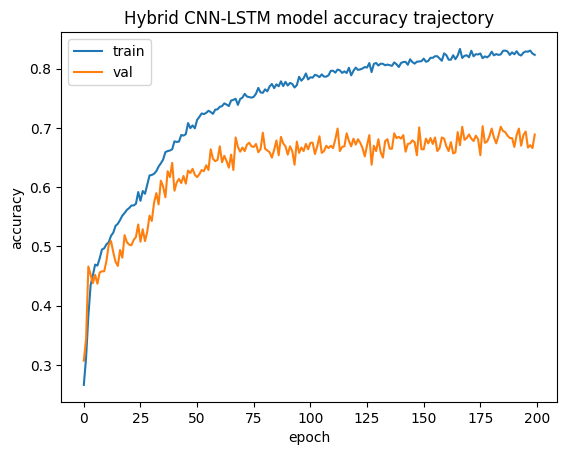

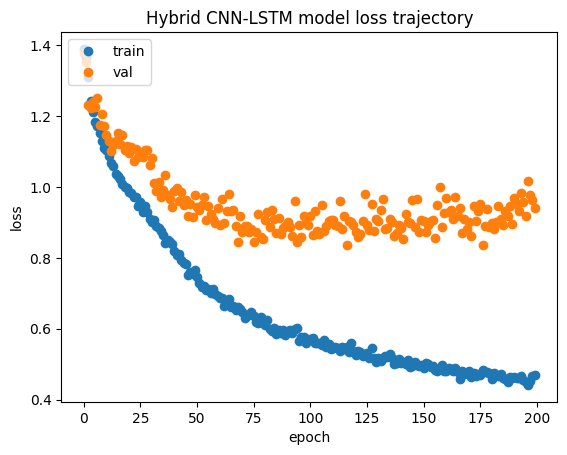

In [17]:
# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


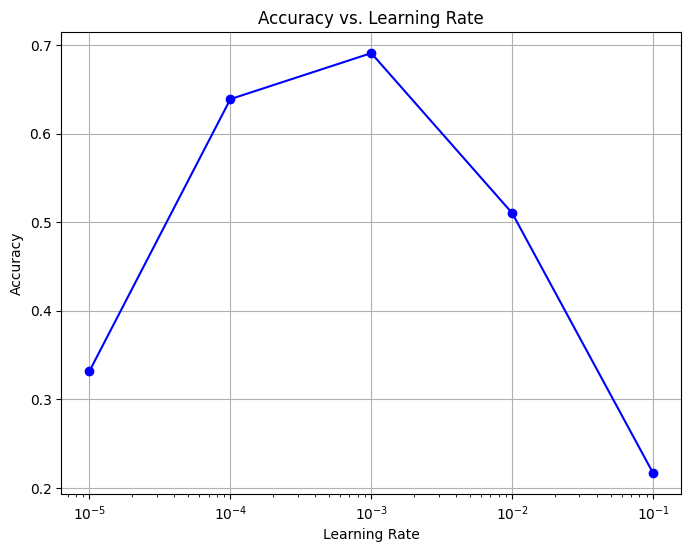

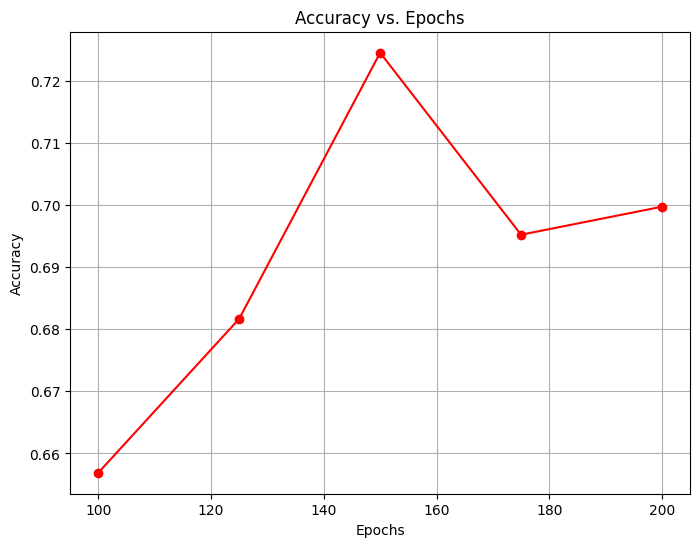

In [18]:
# Plotting testing accuracy vs. learning rate
plt.figure(figsize=(8, 6))
plt.plot(learning_rate, learning_rate_accuracy, marker='o', linestyle='-', color='b')
plt.xscale('log')  
plt.title('Accuracy vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Plotting testing accuracy vs. epochs
plt.figure(figsize=(8, 6))
plt.plot(epochs, epochs_accuracy, marker='o', linestyle='-', color='r')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [19]:
print(learning_rate_accuracy)
print(epochs_accuracy)

[0.33182844519615173, 0.6388261914253235, 0.690744936466217, 0.5101580023765564, 0.21670429408550262]
[0.6568848490715027, 0.6817155480384827, 0.7246049642562866, 0.6952595710754395, 0.6997742652893066]
